In [1]:
"""Calculate correlations between learned and known features."""

'Calculate correlations between learned and known features.'

In [2]:
import os
import numpy as np
import tensorflow as tf
import src.models.utils
import src.utils

class MaskedConv1D(tf.keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True

In [3]:
alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
weights = {'0': 1, '1': 2, '-': 3}
batch_size = 32
model_acc = ["6_2"] # ["3_6_1", "6_2", "7_1_2", "7_2_2", "7_3_2"]

batch_data = src.models.utils.load_data('../../mobidb-pdb_validation/split_data/out/all_seqs.fasta', '../../mobidb-pdb_validation/split_data/out/all_labels.fasta')
batches = src.models.utils.BatchGenerator(batch_data, batch_size, alphabet, weights, shuffle=False)

seq_fasta = src.utils.read_fasta('../../mobidb-pdb_validation/split_data/out/all_seqs.fasta')

window_sizes = [20] #[10,20,30,40,50]

feature_dict = {"chain_expanding_frac":lambda seq:get_X_frac(seq,"EDRKP"),
                "aromatic_frac":lambda seq:get_X_frac(seq,"FYW"),
                "disorder_promoting_frac":lambda seq:get_X_frac(seq,"TAGRDHQKSEP")}

In [4]:
feature_dict = {"S_frac":lambda seq:get_X_frac(seq,"S"),
                "P_frac":lambda seq:get_X_frac(seq,"P"),
                "T_frac":lambda seq:get_X_frac(seq,"T"),
                "A_frac":lambda seq:get_X_frac(seq,"A"),
                "H_frac":lambda seq:get_X_frac(seq,"H"),
                "Q_frac":lambda seq:get_X_frac(seq,"Q"),
                "N_frac":lambda seq:get_X_frac(seq,"N"),
                "G_frac":lambda seq:get_X_frac(seq,"G"),
                "charge_frac":lambda seq:get_X_frac(seq,"DERK"),
                "net_charge":lambda seq:get_X_frac(seq,"RK")-get_X_frac(seq,"DE"),
                "RK_ratio":lambda seq:(get_X_frac(seq,"R")+1)/(get_X_frac(seq,"K")+1),
                "ED_ratio":lambda seq:(get_X_frac(seq,"E")+1)/(get_X_frac(seq,"D")+1),
                "acidic_frac":lambda seq:get_X_frac(seq,"DE"),
                "basic_frac":lambda seq:get_X_frac(seq,"RK"),
                "hydrophobicity":lambda seq:get_hydrophobicity(seq),
                "aliphatic_frac":lambda seq:get_X_frac(seq,"ALMIV"),
                "polarity":lambda seq:get_polarity(seq),
                "polar_frac":lambda seq:get_X_frac(seq,"QNSTGCH"),
                "chain_expanding_frac":lambda seq:get_X_frac(seq,"EDRKP"),
                "aromatic_frac":lambda seq:get_X_frac(seq,"FYW"),
                "disorder_promoting_frac":lambda seq:get_X_frac(seq,"TAGRDHQKSEP"),
                "Q_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"QQ"),
                "N_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"NN"),
                "S_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"SS"),
                "G_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"GG"),
                "E_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"EE"),
                "D_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"DD"),
                "K_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"KK"),
                "R_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"RR"),
                "P_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"PP"),
                "QN_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"QN"),
                "RG_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"RG"),
                "FG_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"FG"),
                "SG_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"SG"),
                "SR_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"SR"),
                "KAP_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"KAP"),
                "PTS_repeat_frac":lambda seq:get_pair_repeat_frac(seq,"PTS")}

In [5]:
# Load models as dictionary of mapping of model name to model
model_dict = {}
for acc in model_acc:
    model_name = f"mobidb-pdb_cnn_{acc}"
    model_path = f"../../models/{model_name}/out_model/{model_name}.h5"
    model = tf.keras.models.load_model(model_path, custom_objects={"MaskedConv1D":MaskedConv1D})
    model_dict[model_name] = model

In [6]:
# Calculate learned features
model_learned_features = {}  # {"model_name":[features learned by model for each protein]}
for model_key in model_dict:
    model = model_dict[model_key]
    layer = model.get_layer("conv1d2")
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
    
    learned_features = []
    for input, _, training_weights, in batches:  # Predict method was acting strange, so extract individual batches
        features = feature_extractor(input).numpy()
        for protein_features, protein_weights in zip(features, training_weights):
            protein_features = protein_features[protein_weights != 0]  # Drop padding
            learned_features.append(protein_features)
    
    model_learned_features[model_key] = learned_features

In [7]:
# Extract accessions
accessions = []
for accession, _, in seq_fasta:
    accessions.append(accession.split("|")[0][1:]) # Keep only acc

In [8]:
# Construct new record objects that contain known and learned features
records = {}  # {model_key:{accession:{seq:,labels:,learned_features:,known_features:{window_size:{known_feature:}}}}}
for model_key in model_dict:
    model_records = {}
    
    for accession, (seq, labels), learned_features in zip(accessions, batch_data, model_learned_features[model_key]):
        known_features = {}
        for window_size in window_sizes:
            window_features = {}
            with open(f"../generate_maps/out/window_size{window_size}/{accession}_feature_map{window_size}.tsv") as file:
                for feature in feature_dict:
                    window_features[feature] = []
            
                for line in file:
                    line_values = line.split("\t")[:-1]  # Remove \n
                    for feature, value in zip(feature_dict.keys(), line_values):
                        window_features[feature].append(float(value))
            
            known_features[f"window{window_size}"] = window_features
        
        model_records[accession] = {"seq": seq,
                                    "labels":labels,
                                    "learned_features":learned_features,
                                    "known_features": known_features}
              
    records[model_key] = model_records

In [9]:
# Construct matrix of learned feature values
# Columns represent positions
# Rows represent features

learned_feature_arrays = []
for model_key in records:
    model_learned_features_lst = [[] for i in range(128)]
        
    for acc in records[model_key]:
        acc_learned_features = np.transpose(records[model_key][acc]["learned_features"])
        for index, acc_learned_feature in enumerate(acc_learned_features):
            model_learned_features_lst[index].append(acc_learned_feature)
            
    model_learned_features_combined_lst = []
    for learned_feature in model_learned_features_lst:
        model_learned_features_combined_lst.append(np.concatenate(learned_feature))
    
    model_learned_features_array = np.array(model_learned_features_combined_lst)
    learned_feature_arrays.append(model_learned_features_array)

In [10]:
# Construct matrix of known feature values
# Columns represent positions
# Rows represent features

known_feature_arrays = []
for model_key in records:
    model_known_features_lst = [[] for i in range(len(feature_dict))]
    
    for index, feature in enumerate(feature_dict):
        for acc in records[model_key]:
            acc_known_features = records[model_key][acc]["known_features"]['window20'][feature]
            model_known_features_lst[index].append(acc_known_features)
                
    model_known_features_combined_lst = []
    for known_feature in model_known_features_lst:
        model_known_features_combined_lst.append(np.concatenate(known_feature))
        
    model_known_features_array = np.array(model_known_features_combined_lst)
    known_feature_arrays.append(model_known_features_array)

In [11]:
# Combine learned features array and known features array for each model into a tuple
record_arrays = {}
for learned_array, known_array, model_key in zip(learned_feature_arrays, known_feature_arrays, records.keys()):
    record_arrays[model_key] = (learned_array, known_array)

In [12]:
# Calculate correlation between known and learned features for each model
import scipy.stats

model_corr = {}
for model_key in record_arrays:
    model_learned_features = record_arrays[model_key][0]
    model_known_features = record_arrays[model_key][1]
    
    model_corr_list = []
    for known_feature in model_known_features:
        known_feature_corrcoefs = []
        for learned_feature in model_learned_features:
            known_feature_corrcoefs.append(scipy.stats.pearsonr(known_feature,learned_feature)[0])
            
        model_corr_list.append(known_feature_corrcoefs)
        
    model_corr_matrix = np.array(model_corr_list)
    model_corr[model_key] = model_corr_matrix

c:\users\jason hong\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

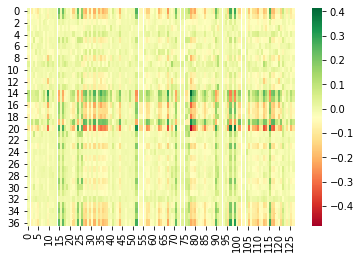

In [14]:
# 6_2
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(model_corr['mobidb-pdb_cnn_6_2'], cmap='RdYlGn')

<AxesSubplot:>

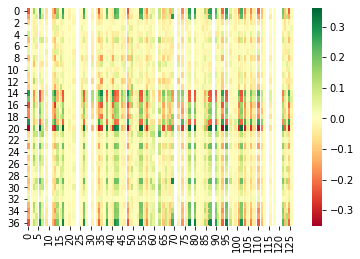

In [132]:
# 3_6_1
import matplotlib.pyplot as plt
import seaborn as sns

#plt.subplots(figsize=(20,20))
sns.heatmap(model_corr['mobidb-pdb_cnn_3_6_1'], cmap='RdYlGn')
#sns.heatmap(model_corr['mobidb-pdb_cnn_3_6_1'], xticklabels=range(1,129), yticklabels=feature_dict.keys(), cmap='RdYlGn')

In [138]:
feature_keys = []
for key in feature_dict:
    feature_keys.append(key)

feature_keys[20]

'disorder_promoting_frac'

In [129]:
len(record_arrays['mobidb-pdb_cnn_3_6_1'][1])

37

In [108]:
for model_key in records:
    model_known_features_dict = {}
    for window_size in window_sizes:
        for feature in feature_dict:
            known_feature_key = f"{feature}"+ f"{window_size}"
            model_known_features_dict[known_feature_key] = []
            
            for acc in records[model_key]:
                acc_known_features = records[model_key][acc]["known_features"][f"window{window_size}"][feature]
                model_known_features_dict[known_feature_key].append(acc_known_features)
                
            acc_known_features_combined = np.concatenate(model_known_features_dict[known_feature_key])
            model_known_features_dict[known_feature_key] = acc_known_features_combined
            
    model_known_features_lst = []
    for known_feature in model_known_features_dict:
        model_known_features_lst.append(model_known_features_dict[known_feature])
        
    model_known_features_array = np.array(model_known_features_lst)

In [87]:
len(model_learned_features_array[0])

10233688

In [64]:
len(model_learned_features_lst[0])

2144

In [50]:
model_learned_features_array = np.empty(shape=[0, 128])
model_learned_features_array = np.vstack([model_learned_features_array,records['mobidb-pdb_cnn_3_6_1']['A5FB55']['learned_features']])
len(model_learned_features_array[0])

128

In [ ]:
for model_key in records:
    model_learned_features_array = np.empty(shape=(128))
    for acc in records[model_key]:
        

In [18]:
# Construct matrix of learned feature values and matrix of known feature values
# Columns represent positions
# Rows represent features
record_arrays = {}

for model_key in records:
    model_learned_features_dict = {}
    for i in range(1,129):
        model_learned_features_dict[i] = []
        
    for acc in records[model_key]:
        acc_learned_features = np.transpose(records[model_key][acc]["learned_features"])
        for i, acc_learned_feature in zip(range(1,129), acc_learned_features):
            model_learned_features_dict[i].append(acc_learned_feature)
            
    for learned_feature in model_learned_features_dict:
        learned_feature_combined = np.concatenate(model_learned_features_dict[learned_feature])
        model_learned_features_dict[learned_feature] = learned_feature_combined
        
    model_learned_features_lst = []
    for learned_feature in model_learned_features_dict:
        model_learned_features_lst.append(model_learned_features_dict[learned_feature])
    
    model_learned_features_array = np.array(model_learned_features_lst)
    
    model_known_features_dict = {}
    for window_size in window_sizes:
        for feature in feature_dict:
            known_feature_key = f"{feature}"+ f"{window_size}"
            model_known_features_dict[known_feature_key] = []
            
            for acc in records[model_key]:
                acc_known_features = records[model_key][acc]["known_features"][f"window{window_size}"][feature]
                model_known_features_dict[known_feature_key].append(acc_known_features)
                
            acc_known_features_combined = np.concatenate(model_known_features_dict[known_feature_key])
            model_known_features_dict[known_feature_key] = acc_known_features_combined
            
    model_known_features_lst = []
    for known_feature in model_known_features_dict:
        model_known_features_lst.append(model_known_features_dict[known_feature])
        
    model_known_features_array = np.array(model_known_features_lst)
    
    record_arrays[model_key] = {"learned": model_learned_features_array, "known": model_known_features_array}

TypeError: array() missing required argument 'object' (pos 1)

In [16]:
model_learned_features_array

NameError: name 'model_learned_features_array' is not defined

In [ ]:
import scipy.stats

In [43]:
type(feature_dict.keys())

dict_keys

In [36]:
len(model_corr['mobidb-pdb_cnn_3_6_1'])

3

In [242]:
# Calculate correlation between known and learned features for each model
model_corr = {}
for model_key in record_arrays:
    model_known_features = record_arrays[model_key]["known"]
    model_learned_features = record_arrays[model_key]["learned"]
    model_corr_matrix = np.corrcoef(model_known_features, model_learned_features)
    model_corr[model_key] = model_corr_matrix

In [243]:
model_corr_matrix

array([[ 1.        ,  0.01080537, -0.01228749, ..., -0.21713452,
         0.01816685,         nan],
       [ 0.01080537,  1.        ,  0.00453934, ..., -0.14631004,
        -0.00993907,         nan],
       [-0.01228749,  0.00453934,  1.        , ..., -0.0394879 ,
         0.00601186,         nan],
       ...,
       [-0.21713452, -0.14631004, -0.0394879 , ...,  1.        ,
        -0.08298673,         nan],
       [ 0.01816685, -0.00993907,  0.00601186, ..., -0.08298673,
         1.        ,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [109]:
model_known_features_dict.keys()

dict_keys(['chain_expanding_frac 20', 'aromatic_frac 20', 'disorder_promoting_frac 20'])

In [24]:
len(np.transpose(records['mobidb-pdb_cnn_3_6_1']['A5FB55']['learned_features'])[0])

505

In [28]:
np.transpose(records['mobidb-pdb_cnn_3_6_1']['A5FB55']['learned_features'])[-2]

array([2.903051  , 1.7324278 , 1.2580488 , 1.5944489 , 2.3398778 ,
       3.303786  , 1.3265775 , 0.13554564, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [26]:
records['mobidb-pdb_cnn_3_6_1']['A5FB55']['learned_features']

array([[0.       , 0.       , 0.       , ..., 0.       , 2.903051 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.7324278,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.2580488,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
# Construct matrix of learned feature values
# Columns represent positions
# Rows represent features

# need concatenate all positions for each feature together (concatenate?)
# make list of rows
# convert list to numpy array